In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from utils.pnl import *
import seaborn as sns
from data_request.data_processing import *
from data_request.features_clustering import *

## Resample and generating features


* hourly EWMA return for momentum $\mu_t$.

* hourly EWM return volatility $\sigma_t$

We set decay rate $\alpha = 0.05$ for EWM calculation.

* swap event : 
    1. hourly number of swaps $N^{(swap)}_t$

    2. hourly mean arrival time of swap event $\Delta_t$ 

    3. hourly total volume(buy + sell) normalized by liquidity $\hat{V}_t$
    
    4. hourly buy/sell volume imbalance  $$\mathcal{I}_t = \frac{V_t^{buy}-V_t^{sell}}{V_t^{buy}+V_t^{sell}}$$ 

* mint/burnt event:
    1. hourly number of mints+burns $N^{(mb)}_t$





In [ ]:
df_swap = pd.read_csv('./data/swap_with_liq.csv').drop(columns='Unnamed: 0')
df_swap['time'] = pd.to_datetime(df_swap['time'])

df_mb = pd.read_csv('./data/mb.csv').drop(columns='Unnamed: 0')
df_mb['time'] = pd.to_datetime(df_mb['time'])

df_features=features_resample(df_swap,df_mb)
# df_features.to_csv('./data/hourly_features.csv')


## Performance estimation 
For each hour, given liquidity $L$ and range, compute corresponding asset Y(USDC) as initial capital, set return as reward/ini_cap = (fee-LVR-gas)/ini_cap, no compound to evaluate the baseline performance of liquidity provision. Here we choose $\pm 5\%$ around the pool price and $L$ be the historical average liquidity at the tick corresponding to the price. 

In [ ]:

gas = 5
# result = pnl(df_features.reset_index(),gas=gas)
L = int(2.6162685701074442e+17)
result =  pnl_fix_range(df_features.reset_index(),L,gas)
df_features['return'] = result['return'].values
df_features['return_next_hr'] = result['return'].shift(-1).values


## Features EDA

In [ ]:
IS_end='2024-01-29 19:00'
df_features_IS = df_features[df_features.index<=IS_end]
df_features_IS = df_features_IS[['volume_imbalance', 'scaled_total_volume', 'n_swap','n_mb' ,'closed_price',
       'interval_swap', 'liquidity', 'tick', 'R_ewma', 'volatility_ewm',
       'ma24', 'ma168', 'bb_upper', 'bb_middle', 'bb_lower', 'adxr', 'dx',
       'return', 'return_next_hr']]

### In sample features correlation

Text(0.5, 1.0, 'In sample correlation')

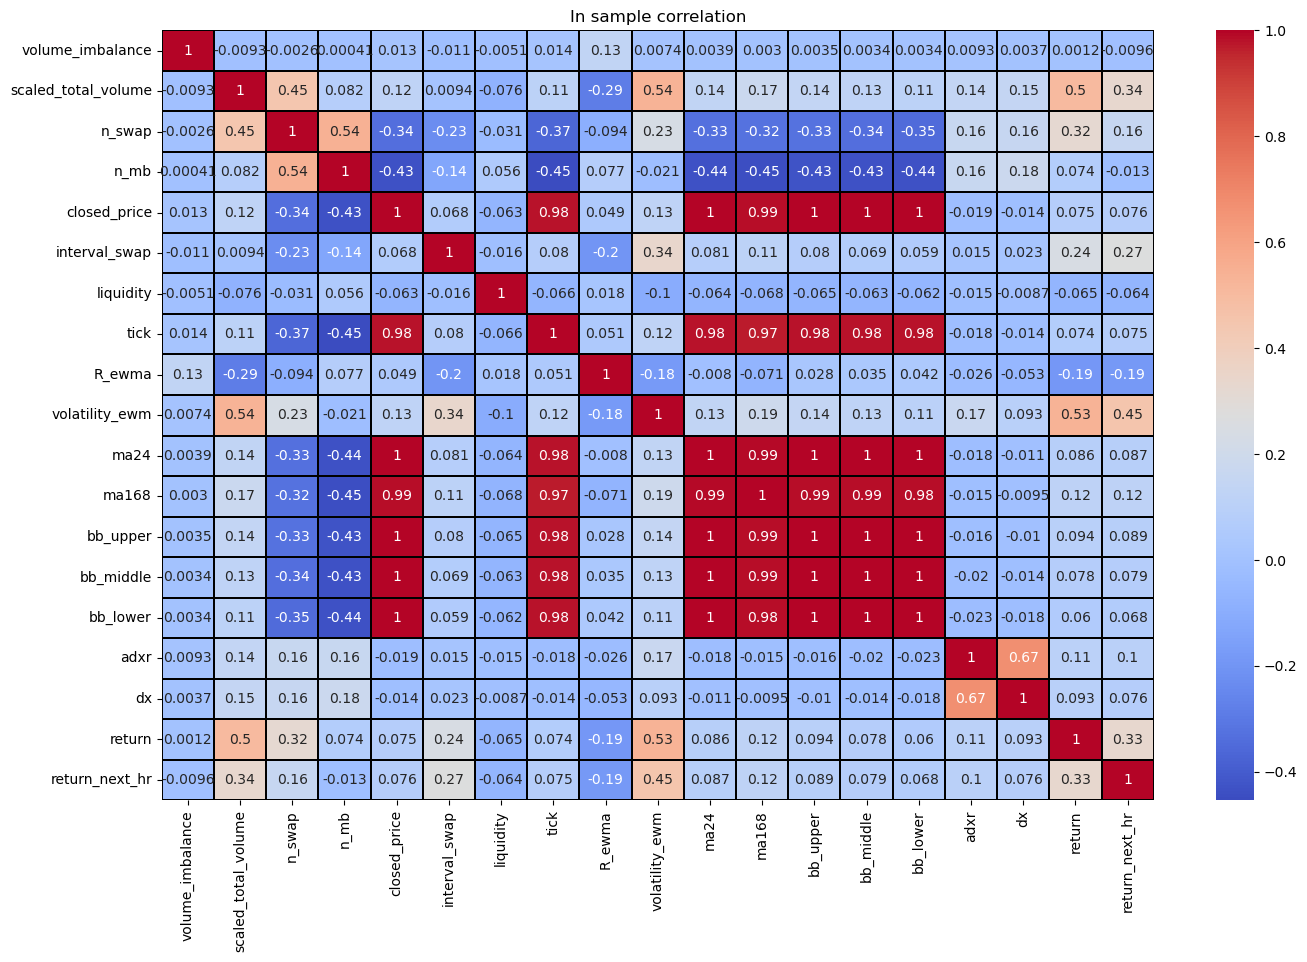

In [ ]:
plt.figure(figsize=(16,10))
sns.heatmap( df_features_IS.corr()
                    ,cmap='coolwarm',cbar=True,annot=True,
                 linewidth=0.01,linecolor='k')
plt.title('In sample correlation')


* n_swp and total volume has high correlation.

* n_mb are correlated to n_swap.

* price is negative correlated with n_swap and n_mb

* volatility is postive correlated with total volume and LP return. Total is also postive correlated with LP return.

* liquidity,volume imbalance seems to have low correlation with others features.


## Clustering

In [ ]:
features_list_all =['volume_imbalance','scaled_total_volume', 'n_swap',
       'interval_swap', 'R_ewma', 'volatility_ewm',
       'ma24', 'ma168', 'bb_upper', 'bb_middle', 'bb_lower', 'adxr', 'dx',
       'n_mb']

features_list_micro =['volume_imbalance', 'scaled_total_volume', 'n_swap',
       'interval_swap', 'R_ewma', 'volatility_ewm',
       'n_mb']

For out-of-sample features normalization, we choose a two-month look back window for normalization to avoid look ahead.

In [ ]:
km_all,df_all = clustering(df_features,features_list_all,3)


### PCA regime visualization

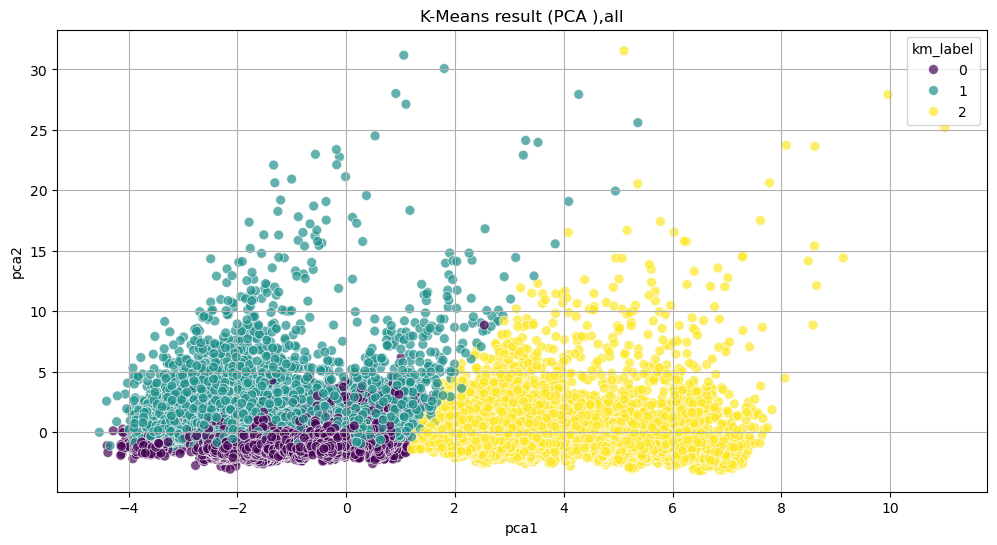

In [ ]:
df_all_IS = df_all[df_all.index<=IS_end].copy()
plot_pca(df_all_IS,'all')
    

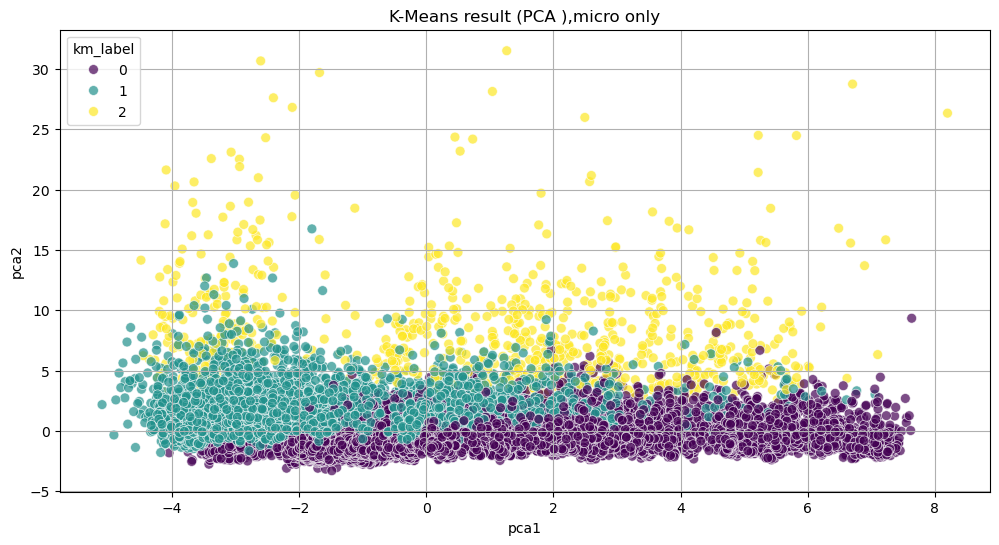

In [ ]:
km_micro,df_micro = clustering(df_features,features_list_micro,3)
df_micro_IS = df_micro[df_micro.index<=IS_end].copy()
plot_pca(df_micro_IS,'micro only')


### Centroids of each regime
We plot the centroid of each regime(in sample) as heatmap, also we add ```return_norm``` and 
```return_next_hr_norm``` as the normalized LP return and return at next hour as an evaluation of overall performance of liquidity provision at each regime. We name the labels such that they increases w.r.t the average next-hour return.

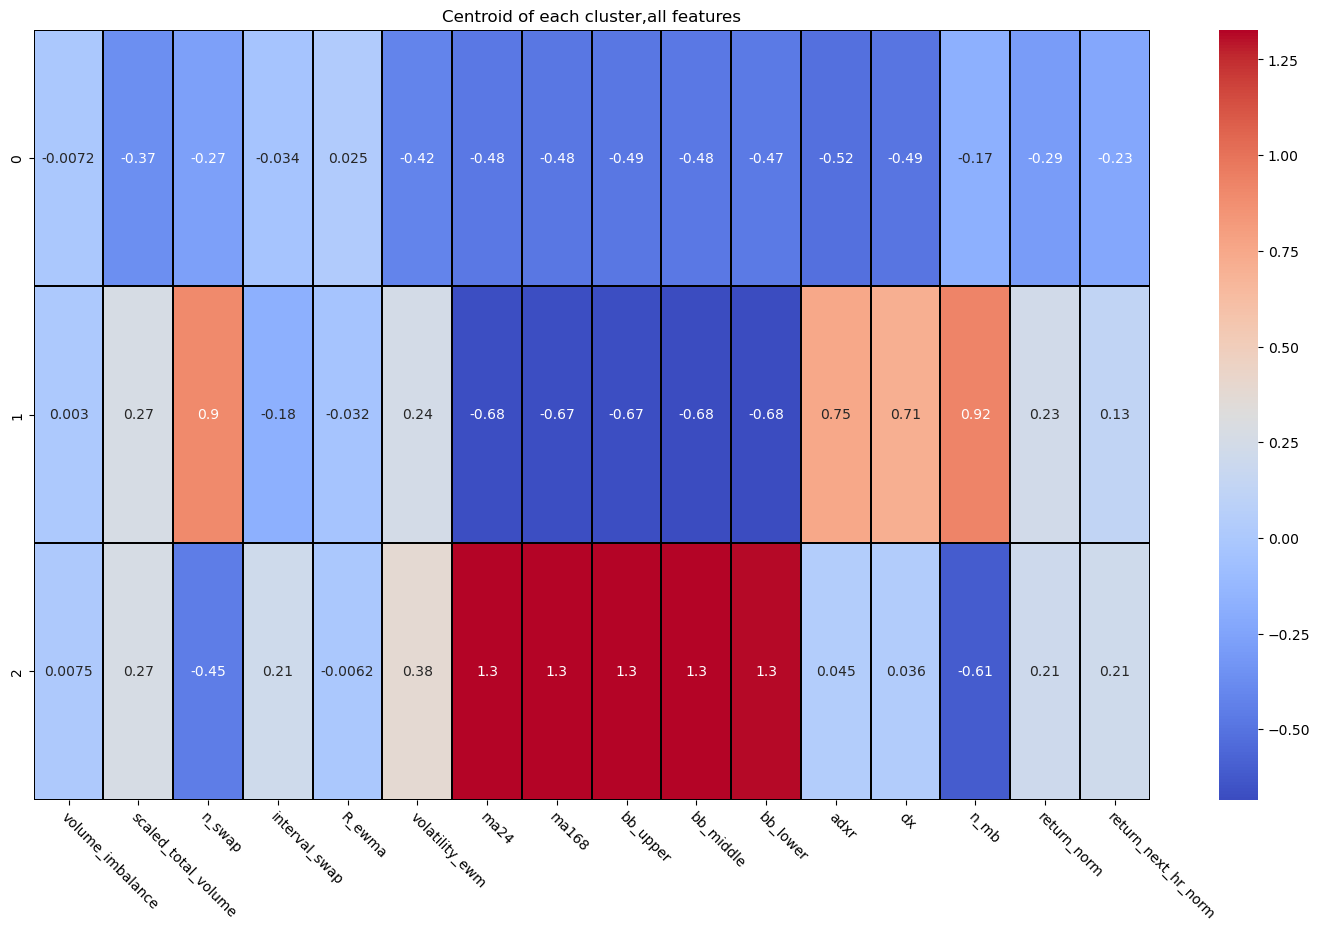

In [ ]:
plot_cen_hm(df_all_IS,km_all,'all features')

Use only microstructure features only.

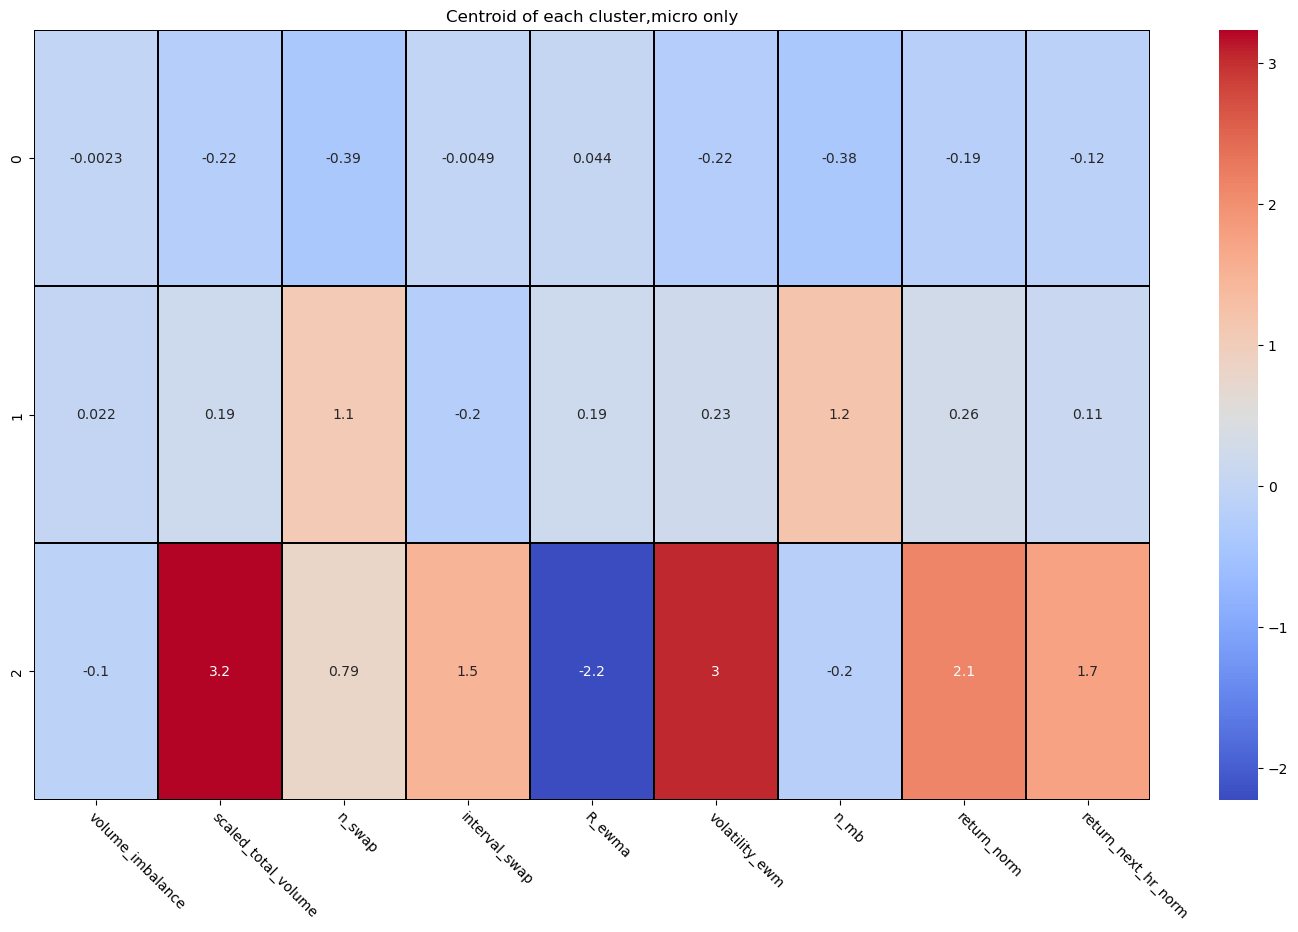

In [ ]:
plot_cen_hm(df_micro_IS,km_micro,'micro only')

* Regime 0:　Lower absolute values of features , having worst LP performance.
* Regime 1: Higher values of numbers of swaps and mints/burns, positive LP performance but 
  next hour return(after LP constructs position) is less than the past return (before LP constructs position).
* Regime 2: Highest next hour return. When using micro features only, the absolute features     
  values  are significantly higher than other regimes.

In [ ]:
keep_list =  ['scaled_volume_WETH','scaled_volume_USDC','closed_price','km_label']
df_all[features_list_all+keep_list].to_csv('./data/hourly_features_all.csv')
df_micro[features_list_micro+keep_list].to_csv('./data/hourly_features_micro.csv')

In [ ]:
df_all.to_csv('df_all.csv')
df_micro.to_csv('df_micro.csv')

## Regime timeseries visualization

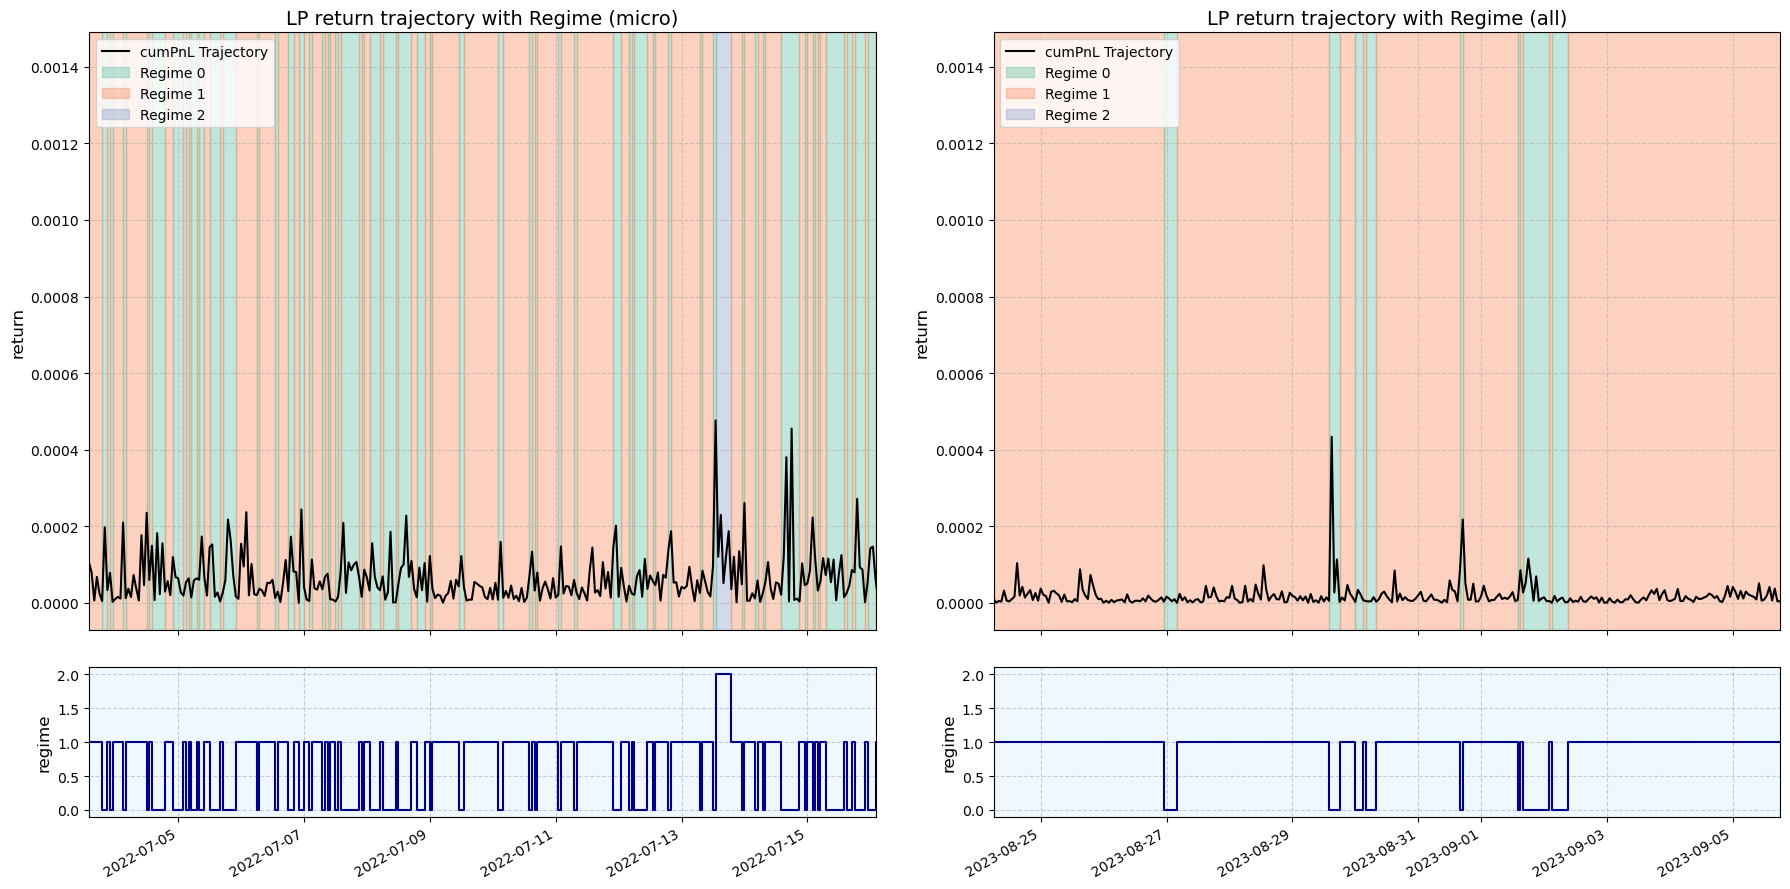

In [ ]:

fig, ax = plt.subplots(
    2, 2,
    figsize=(18, 9),
    sharex='col',
    gridspec_kw={'height_ratios': [4, 1]}
)

plot_one_dataset(
    ax_main=ax[0, 0], ax_sub=ax[1, 0],
    df=df_micro, title='LP return trajectory with Regime (micro)',
    xlim=(df_micro.index[10000], df_micro.index[10300])  
)

plot_one_dataset(
    ax_main=ax[0, 1], ax_sub=ax[1, 1],
    df=df_all, title='LP return trajectory with Regime (all)',
    xlim=(df_all.index[20000], df_all.index[20300])      
)

fig.autofmt_xdate()
plt.tight_layout()
plt.subplots_adjust(hspace=0.1, wspace=0.15)
plt.show()

 Regime 0 accounts for the largest proportion. Proportion of regime 2 decreases to one tehnth if we only consider microstructure features.

In [ ]:
ratio_dict = {'all':[],'micro':[]}
for i,df in {'all':df_all,'micro':df_micro}.items():
    N=len(df)
    for j in range(3):    
        ratio_dict[i].append(len(df[df.km_label==j])/N)
pd.DataFrame(ratio_dict)

,all,micro
0,0.413890,0.723201
1,0.265371,0.241439
2,0.320739,0.035360


## Correlation of labels and next hour return
When only choosing microstructure features, labels and  next hour returns have higher correlation.

In [ ]:
df_micro[['km_label','return_next_hr']].corr()


,km_label,return_next_hr
km_label,1.000000,0.278017
return_next_hr,0.278017,1.000000


In [ ]:
df_all[['km_label','return_next_hr']].corr()


,km_label,return_next_hr
km_label,1.000000,0.181025
return_next_hr,0.181025,1.000000
